In [1]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [3]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [-10, 50, -20, 20] # xxx
        self.box = [0, 40, -10, 10] # xxx
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def set_to(self, x, y, theta0, theta1, ϕ):
        self.θ0 = theta0
        self.θ1 = theta1
        self.x = x
        self.y = y
        self.ϕ = ϕ
        if self.display: self.draw()
    
    def reset(self, ϕ=0, xrange=1.0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random()) * self.box[1] * xrange
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ, xrange)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


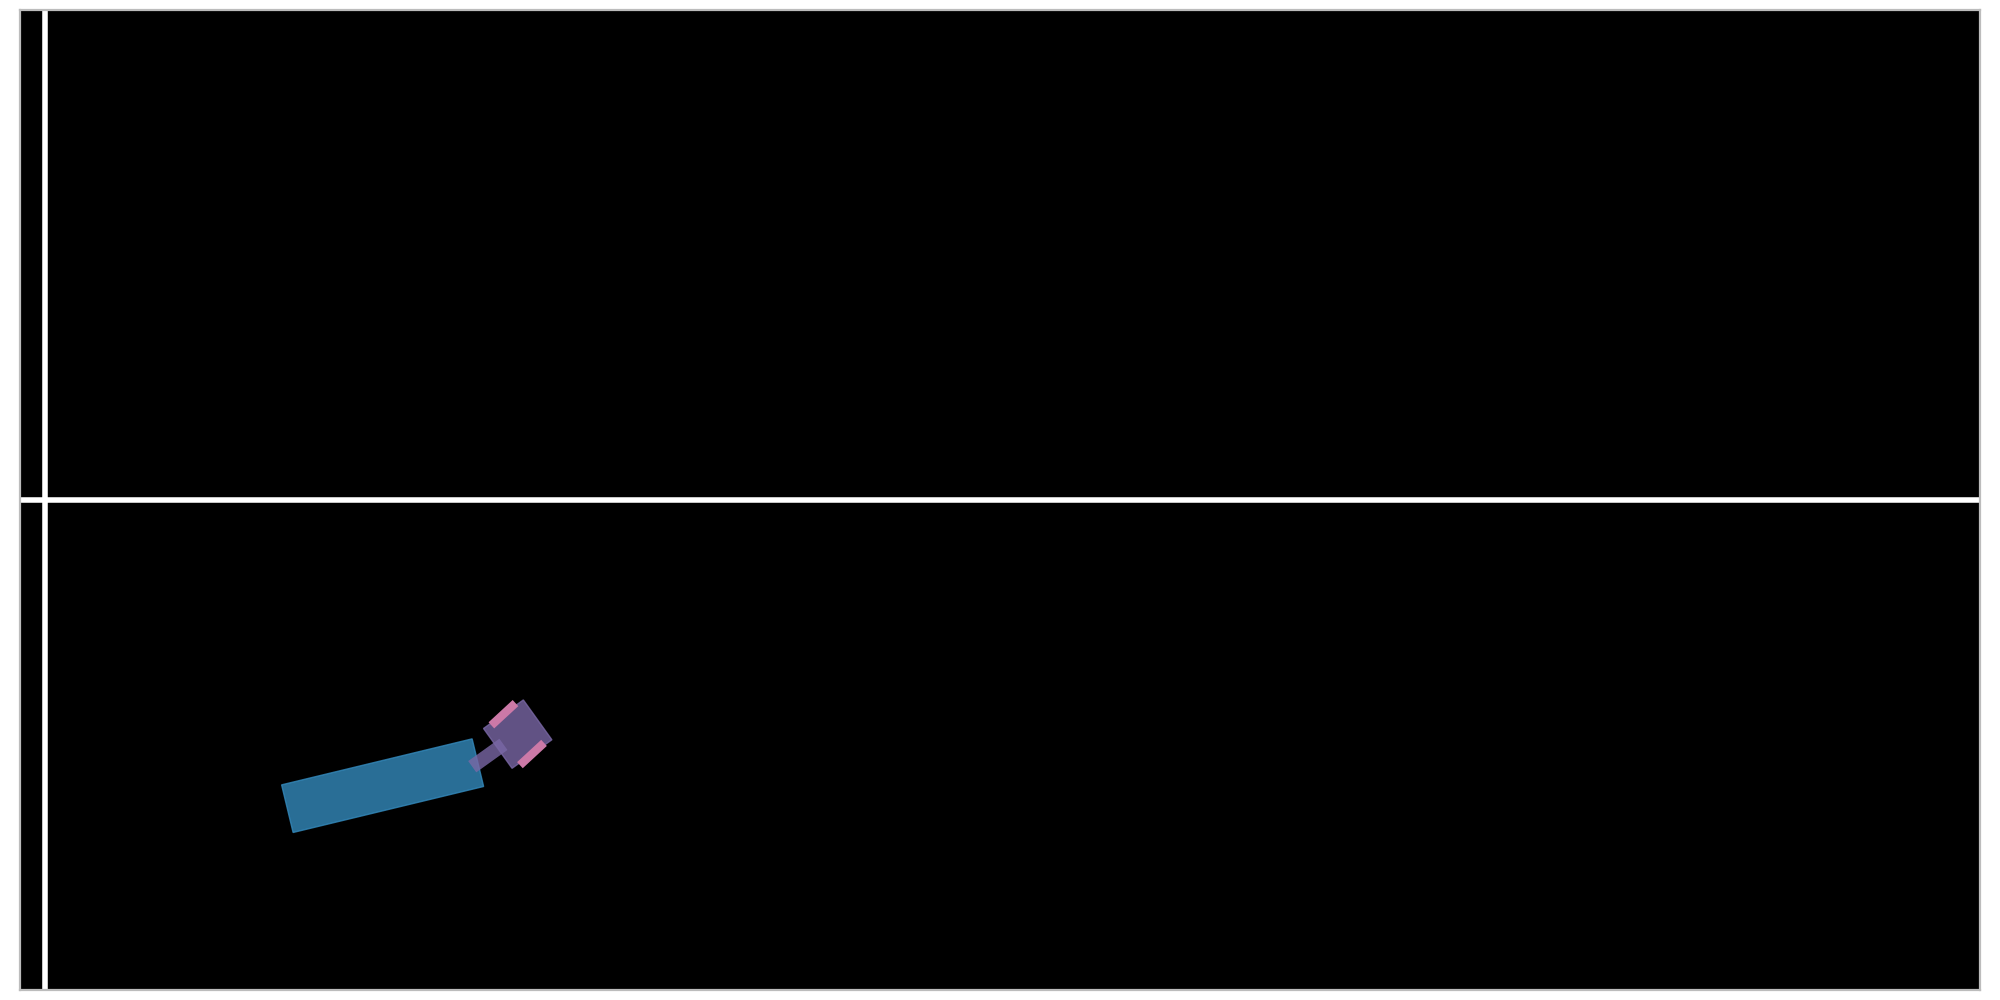

In [4]:
truck_display = Truck(display=True)

In [5]:
ϕ = deg2rad(0)  # positive left, negative right
truck_display.step(ϕ)
truck_display.draw()

In [5]:
truck_display.reset()
# truck_display.set_to(4,0,0,0)

In [6]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

In [7]:
# Build expert data set

inputs = list()
outputs = list()

def build_data_set():
    episodes = 10
    truck = truck_display
    truck = Truck(); episodes = 10_000  # uncomment for creating the data set

    for episode in tqdm(range(episodes)):

        truck.reset()

        while truck.valid():
            initial_state = truck.state()
            ϕ = (random() - 0.5) * π / 2
            inputs.append((ϕ, *initial_state))
            outputs.append(truck.step(ϕ))
            truck.draw()

build_data_set()

100%|██████████| 10000/10000 [00:14<00:00, 694.20it/s]


In [8]:
len(inputs), len(outputs)

(585681, 585681)

In [9]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [10]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

In [11]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
print(mean, std)
mean = torch.Tensor([ 1.8700e-04,  2.2902e+01, -6.6973e-03,  3.0787e+00,  2.2942e+01, -8.4272e-03,  3.1174e+00])
std = torch.Tensor([ 0.4535, 13.8940, 10.0473,  1.8923, 14.4000, 10.4339,  2.0513])
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

tensor([-0.0010, 19.9964,  0.0023,  3.1505, 19.9637,  0.0247,  3.1423]) tensor([ 0.4536, 10.0788,  4.6683,  1.8703, 10.4435,  5.2437,  2.0586])


In [12]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.99) # xxx
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

585681 579824


In [13]:
len(train_inputs)

579824

In [14]:
learning_rate = 5e-4
def adjust_learning_rate(optimizer, epoch):
    """decrease learning rate every 1000 epochs"""
    lr = learning_rate
    lr = learning_rate * (0.85 ** (epoch // 1000))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [26]:
# train the emulator

cnt = 0
loss_total = 0

for epoch in range(10):
    for i in torch.randperm(len(train_inputs)):
        adjust_learning_rate(optimiser_e, cnt / 1_000)

        ϕ_state = train_inputs[i]
        next_state_prediction = emulator(ϕ_state)

        next_state = train_outputs[i]
        loss = criterion(next_state_prediction, next_state)
        loss_total += loss.item()

        optimiser_e.zero_grad()
        loss.backward()
        optimiser_e.step()

        if (cnt + 1) % 10_000 == 0:
            print(f'{cnt + 1:4d} / {len(train_inputs)}, avg loss: {loss_total/10_000.:.10f}')
            loss_total = 0
        cnt += 1

10000 / 579824, avg loss: 0.0000804347
20000 / 579824, avg loss: 0.0000791593
30000 / 579824, avg loss: 0.0000845438
40000 / 579824, avg loss: 0.0000845858
50000 / 579824, avg loss: 0.0000802830
60000 / 579824, avg loss: 0.0000811295
70000 / 579824, avg loss: 0.0000827059
80000 / 579824, avg loss: 0.0000769306
90000 / 579824, avg loss: 0.0000788360
100000 / 579824, avg loss: 0.0000819462
110000 / 579824, avg loss: 0.0000794767
120000 / 579824, avg loss: 0.0000794280
130000 / 579824, avg loss: 0.0000797386
140000 / 579824, avg loss: 0.0000772653
150000 / 579824, avg loss: 0.0000793249
160000 / 579824, avg loss: 0.0000800445
170000 / 579824, avg loss: 0.0000825344
180000 / 579824, avg loss: 0.0000785427
190000 / 579824, avg loss: 0.0000789275
200000 / 579824, avg loss: 0.0000837400
210000 / 579824, avg loss: 0.0000787700
220000 / 579824, avg loss: 0.0000751683
230000 / 579824, avg loss: 0.0000801498
240000 / 579824, avg loss: 0.0000765259
250000 / 579824, avg loss: 0.0000769892
260000 / 

2040000 / 579824, avg loss: 0.0000549008
2050000 / 579824, avg loss: 0.0000542665
2060000 / 579824, avg loss: 0.0000543215
2070000 / 579824, avg loss: 0.0000538524
2080000 / 579824, avg loss: 0.0000573207
2090000 / 579824, avg loss: 0.0000524731
2100000 / 579824, avg loss: 0.0000540782
2110000 / 579824, avg loss: 0.0000542375
2120000 / 579824, avg loss: 0.0000535242
2130000 / 579824, avg loss: 0.0000544395
2140000 / 579824, avg loss: 0.0000520484
2150000 / 579824, avg loss: 0.0000578203
2160000 / 579824, avg loss: 0.0000558486
2170000 / 579824, avg loss: 0.0000527998
2180000 / 579824, avg loss: 0.0000549680
2190000 / 579824, avg loss: 0.0000516024
2200000 / 579824, avg loss: 0.0000525109
2210000 / 579824, avg loss: 0.0000533415
2220000 / 579824, avg loss: 0.0000557910
2230000 / 579824, avg loss: 0.0000548298
2240000 / 579824, avg loss: 0.0000525445
2250000 / 579824, avg loss: 0.0000550577
2260000 / 579824, avg loss: 0.0000523914
2270000 / 579824, avg loss: 0.0000510766
2280000 / 579824

KeyboardInterrupt: 

In [28]:
# Test
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

    ""
print(f'Test loss: {total_loss / len(test_inputs):.10f}')

Test loss: 0.0000439238


In [29]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR
def normalize(state):
    return (state - mean[1:]) / std[1:]
def denormalize(state):
    return state * std[1:] + mean[1:]

In [30]:
hidden_units_c = 25
controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size)
)
optimiser_c = SGD(controller.parameters(), lr=1e-4)

We need to run the following cell 3 times:
- The first time we try to make θ0 = θ1 when it terminate, which means avoiding jackknife
- The second time we add position information in loss function, try to make the model drive the truck to the left point
- The third time we use the 6-tuple state to make the truck lie horrizontally.

In [41]:
target_state = torch.Tensor([4, 0, 0, 0, 0, 0])
target_state = normalize(target_state)
truck = Truck()

def train_c(criterion_c):
    controller.train()
    
    epocs = 50000 # uncomment to do hard-core training
    loss_total = 0
    for epoc in range(epocs):
        adjust_learning_rate(optimiser_c, epoc)
        step_limit = 1000 # in case of looping around

        truck.reset(xrange=0.8)
        state = torch.Tensor(truck.state())
        state = normalize(state)

        while truck.valid():
            step_limit -= 1
            ϕ = controller(state)
            realϕ = (ϕ * std[0] + mean[0]) # ϕ is normalized
            
            inputs.append((realϕ.item(), *truck.state()))
            outputs.append(truck.step(realϕ.item()))

            state = emulator(torch.cat((ϕ, state), 0))
            
            # use truck class to check and stop one forward propagation
            state_data = denormalize(state).data
            truck.set_to(state_data[0], state_data[1], state_data[2], state_data[-1], realϕ.item())

            if (epoc) % 1 == 0:
                # visualize the result every 200 epochs.
                truck_display.set_to(state_data[0], state_data[1], state_data[2], state_data[-1], realϕ.item())
                time.sleep(0.01)
            if step_limit < 0:
                break

        loss = criterion_c(state, target_state)
        optimiser_c.zero_grad()
        loss.backward()
        # only update controller
        optimiser_c.step()
        loss_total += loss
        epoc_batch_size = 200
        if epoc != 0 and epoc % epoc_batch_size == 0:
            avg_loss = loss_total / epoc_batch_size
            print(f'epoch[{epoc}]: avg_loss: {avg_loss}')
            truck_display.set_to(state_data[0], state_data[1], state_data[2], state_data[-1], (ϕ * std[0] + mean[0]).item())
            if(avg_loss < 0.1):
                print("early termination")
                return
            loss_total = 0

In [42]:
mse = nn.MSELoss()
def loss_jackknife(state):
    return mse(state[2], state[5])

def loss_angle(state, target):
    return mse(state[5], target[5])

def loss_position(state, target):
    return mse(state[:2], target[:2])

def criterion_1(state, target):
    # Train the controller to avoid jackknife
    return loss_jackknife(state)

def criterion_2(state, target):
    # Try to stop with angle 0, and keep avoiding jackknife
    return 0.3 * loss_jackknife(state) + 0.7 * loss_angle(state, target)

def criterion_21(state, target):
    # Try to stop with angle 0, and keep avoiding jackknife
    return loss_jackknife(state) + loss_position(state, target)

def criterion_3(state, target):
    # reach the position
    return 5*loss_jackknife(state) + 0.3 * loss_angle(state, target) + 2 * (loss_position(state, target)**2)

In [43]:
train_c(criterion_1)
# train_c(criterion_21)
# train_c(criterion_3)

KeyboardInterrupt: 

In [ ]:
"""Run this function and look at the above display window"""
def visualize_results():
    controller.eval()
    truck_display.reset(xrange=0.6)
    state = torch.Tensor(truck_display.state())
    state = normalize(state)
    while truck_display.valid():
        ϕ = controller(state)
        realϕ = (ϕ * std[0] + mean[0])
        truck_display.step(ϕ.item())
        truck_display.draw()
        time.sleep(0.01)
        state = normalize(torch.Tensor(truck_display.state()))
        

for i in range(20):
    visualize_results()

In [46]:
model_file = './controller.pth'
def save_controller(controller):
    torch.save(controller.state_dict(), model_file)

def load_controller(controller):
    controller.load_state_dict(torch.load(model_file))


# save_controller(controller)
# torch.save(emulator.state_dict(), './emulator.pth')

load_controller(controller)
# emulator.load_state_dict(torch.load('./emulator.pth'))